<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [4]:
import os
import random
from collections import deque

import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn.utils.spectral_norm as spectral_norm
import torchvision.transforms as tt
import torchvision.utils as tvutils
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid, save_image
from tqdm.notebook import tqdm

%matplotlib inline

sns.set(style="darkgrid", font_scale=1.2)

In [3]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")
device

device(type='mps')

## Часть 1. Подготовка данных (0.5 балла)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/file/d/1inyvLrN5wKBGCxQ4znMKBc64uL4uP_2x/view?usp=drive_link)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [6]:
def get_dataloader(image_size, batch_size):
    """
    Builds dataloader for training data.
    Use tt.Compose and tt.Resize for transformations
    :param image_size: height and wdith of the image
    :param batch_size: batch_size of the dataloader
    :returns: DataLoader object
    """
    # TODO: resize images, convert them to tensors and build dataloader
    transform = tt.Compose(
        [
            tt.Resize(image_size),
            tt.ToTensor(),
            tt.Normalize(
                mean=[0.5, 0.5, 0.5],
                std=[0.5, 0.5, 0.5],
            ),
        ]
    )
    dataset = ImageFolder("data/", transform=transform)
    dataloader = DataLoader(
        dataset,
        batch_size,
        shuffle=True,
        drop_last=True,
    )
    return dataloader

In [7]:
IMAGE_SIZE = 128
BATCH_SIZE = 64
# BATCH_SIZE = 128
# TODO: build dataloader and transfer it to device
dataloader = get_dataloader(image_size=IMAGE_SIZE, batch_size=BATCH_SIZE)
dataloader

In [8]:
batch = next(iter(dataloader))[0]
img = batch[0]
img.min(), img.max(), img.mean(), img.std()

(tensor(-0.9451), tensor(1.), tensor(0.1685), tensor(0.4762))

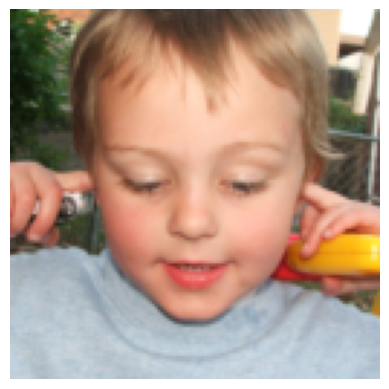

In [9]:
norm = matplotlib.colors.CenteredNorm(halfrange=1)
plt.imshow(norm(img.permute(1, 2, 0)))
plt.axis("off")
plt.show()

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [94]:
LATENT_DIM = 512

In [95]:
discriminator = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(16),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False),
    # nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
    nn.LeakyReLU(0.2, inplace=True),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(256, 1),
    nn.Sigmoid(),
).to(device)

# generator = nn.Sequential(
#     nn.Linear(LATENT_DIM, 8 * 16 * 16),
#     nn.ReLU(inplace=True),
#     nn.Unflatten(1, (8, 16, 16)),
#     nn.ConvTranspose2d(8, 512, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(512),
#     nn.ReLU(inplace=True),
#     nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
#     # nn.BatchNorm2d(256),
#     nn.ReLU(inplace=True),
#     nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
#     # nn.BatchNorm2d(128),
#     nn.ReLU(inplace=True),
#     nn.Conv2d(128, 3, kernel_size=3, stride=1, padding=1),
#     nn.Tanh(),
# ).to(device)
generator = nn.Sequential(
    # Входной слой: латентный вектор -> тензор 8x8x1024
    nn.Linear(LATENT_DIM, 1024 * 8 * 8),
    nn.ReLU(True),
    nn.Unflatten(1, (1024, 8, 8)),
    # Первый слой ConvTranspose2d: 8x8x1024 -> 16x16x512
    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # Второй слой ConvTranspose2d: 16x16x512 -> 32x32x256
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # Третий слой ConvTranspose2d: 32x32x256 -> 64x64x128
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Четвертый слой ConvTranspose2d: 64x64x128 -> 128x128x64
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # Выходной слой ConvTranspose2d: 128x128x64 -> 128x128x3
    nn.ConvTranspose2d(64, 3, kernel_size=3, stride=1, padding=1, bias=False),
    nn.Tanh(),  # Используем Tanh для нормализации выходных значений в диапазоне [-1, 1]
).to(device)

In [96]:
discriminator(batch.to(device)).shape

torch.Size([128, 1])

In [97]:
sample = torch.randn(BATCH_SIZE, LATENT_DIM).to(device)
generator(sample).shape

torch.Size([128, 3, 128, 128])

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [61]:
class BatchBuffer:
    def __init__(self, max_size: int = 5):
        with torch.no_grad():
            self.buffer = [
                generator(torch.randn(BATCH_SIZE, LATENT_DIM).to(device)) for _ in range(max_size)
            ]

    def add_and_sample[B](self, batch: B) -> B:
        if random.random() > 0.25:
            idx = random.randint(0, len(self.buffer) - 1)
            old_batch = self.buffer[idx]
            self.buffer[idx] = batch
            return old_batch
        else:
            return batch


buffer = BatchBuffer(max_size=5)

In [62]:
def init_weights(model):
    if isinstance(model, nn.Conv2d) or isinstance(model, nn.ConvTranspose2d):
        torch.nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif isinstance(model, nn.BatchNorm2d):
        torch.nn.init.normal_(model.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(model.bias.data, 0)

In [71]:
init_weights(generator)
init_weights(discriminator)

In [102]:
def fit(
    generator: nn.Module,
    discriminator: nn.Module,
    epochs: int,
    disc_lr: float,
    gen_lr: float,
    dataloader: DataLoader,
) -> tuple[list[float], list[float]]:
    criterion = F.mse_loss
    # criterion = F.binary_cross_entropy

    disc_optimizer = torch.optim.AdamW(discriminator.parameters(), lr=disc_lr, betas=(0.5, 0.999))
    gen_optimizer = torch.optim.AdamW(generator.parameters(), lr=gen_lr, betas=(0.5, 0.999))
    schedule = {"step_size": 5, "gamma": 0.8}
    gen_scheduler = torch.optim.lr_scheduler.StepLR(gen_optimizer, **schedule)
    disc_scheduler = torch.optim.lr_scheduler.StepLR(disc_optimizer, **schedule)

    zeros_batch = torch.zeros(BATCH_SIZE, 1).to(device)
    ones_batch = torch.ones(BATCH_SIZE, 1).to(device) * 0.9  # label smoothing

    disc_losses = []
    gen_losses = []
    for epoch in tqdm(range(epochs), desc="Epochs"):
        epoch_disc_losses = []
        epoch_gen_losses = []
        for i, (real_batch, _) in enumerate(tqdm(dataloader, desc="Batches", leave=False)):
            real_batch = real_batch.to(device)
            noise = torch.randn(BATCH_SIZE, LATENT_DIM).to(device)
            fake_batch = generator(noise)
            # fake_batch = buffer.add_and_sample(fake_batch)

            # Discriminator step
            if i % 3 == 0:  # discriminator only trains every other epoch
                disc_real_pred = discriminator(real_batch)
                disc_real_loss = criterion(disc_real_pred, ones_batch)

                disc_fake_pred = discriminator(fake_batch.detach())
                disc_fake_loss = criterion(disc_fake_pred, zeros_batch)

                disc_loss = (disc_real_loss + disc_fake_loss) / 2

                discriminator.zero_grad()
                disc_loss.backward()
                disc_optimizer.step()

                epoch_disc_losses.append(disc_loss.item())

            # Generator step
            ones_batch = torch.ones(BATCH_SIZE, 1).to(device) * 0.9  # label smoothing

            disc_fake_pred = discriminator(fake_batch)
            gen_loss = criterion(disc_fake_pred, ones_batch)

            generator.zero_grad()
            gen_loss.backward()
            gen_optimizer.step()

            epoch_gen_losses.append(gen_loss.item())

            disc_real_accuracy = (disc_real_pred > 0.5).float().mean().item()
            disc_fake_accuracy = (disc_fake_pred < 0.5).float().mean().item()
            gen_accuracy = (disc_fake_pred > 0.5).float().mean().item()

        disc_scheduler.step()
        gen_scheduler.step()

        disc_loss = np.mean(epoch_disc_losses)
        gen_loss = np.mean(epoch_gen_losses)

        disc_losses.append(disc_loss)
        gen_losses.append(gen_loss)

        print(
            f"Epoch {epoch + 1}/{epochs}\t"
            f"Discriminator loss: {disc_loss:.4f}, Generator loss: {gen_loss:.4f}\n"
            f"Accuracy\tdisc real: {disc_real_accuracy}, disc fake: {disc_fake_accuracy}, gen: {gen_accuracy}"
        )
        img_grid_fake = tvutils.make_grid(fake_batch[:3], padding=1, pad_value=1, normalize=True)
        plt.imshow(img_grid_fake.permute(1, 2, 0).cpu())
        plt.axis("off")
        plt.show()

    return disc_losses, gen_losses

Epochs:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 1/16	Discriminator loss: 0.2047, Generator loss: 0.1946
Accuracy	disc real: 0.0, disc fake: 1.0, gen: 0.0


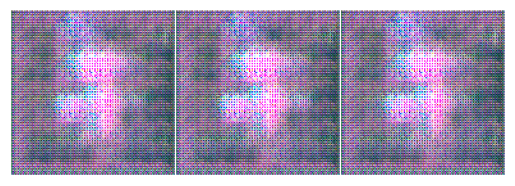

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2/16	Discriminator loss: 0.2049, Generator loss: 0.1887
Accuracy	disc real: 0.0, disc fake: 1.0, gen: 0.0


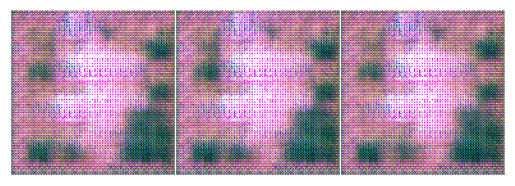

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3/16	Discriminator loss: 0.2043, Generator loss: 0.1927
Accuracy	disc real: 0.0, disc fake: 1.0, gen: 0.0


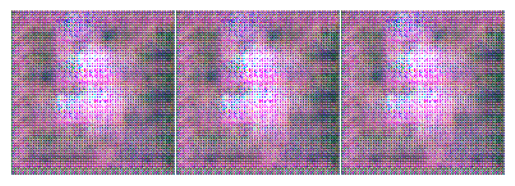

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4/16	Discriminator loss: 0.2042, Generator loss: 0.1911
Accuracy	disc real: 0.0, disc fake: 1.0, gen: 0.0


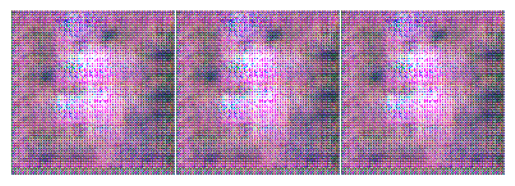

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5/16	Discriminator loss: 0.2039, Generator loss: 0.1909
Accuracy	disc real: 0.0, disc fake: 1.0, gen: 0.0


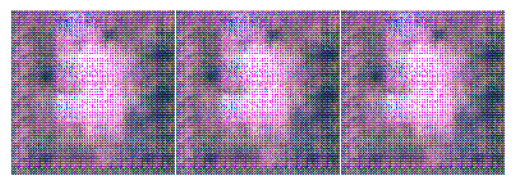

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6/16	Discriminator loss: 0.2038, Generator loss: 0.1933
Accuracy	disc real: 0.0, disc fake: 1.0, gen: 0.0


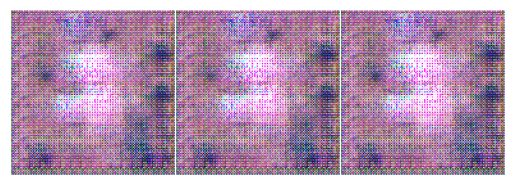

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7/16	Discriminator loss: 0.2036, Generator loss: 0.1924
Accuracy	disc real: 0.0, disc fake: 1.0, gen: 0.0


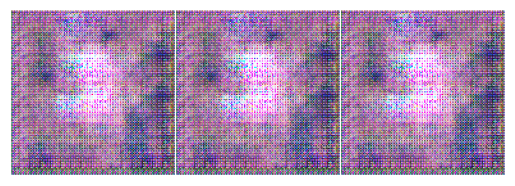

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8/16	Discriminator loss: 0.2034, Generator loss: 0.1927
Accuracy	disc real: 0.0, disc fake: 1.0, gen: 0.0


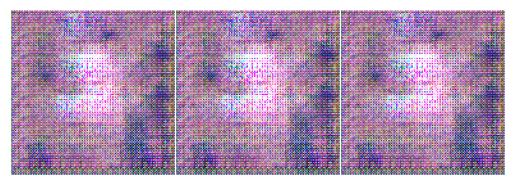

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9/16	Discriminator loss: 0.2033, Generator loss: 0.1930
Accuracy	disc real: 0.0, disc fake: 1.0, gen: 0.0


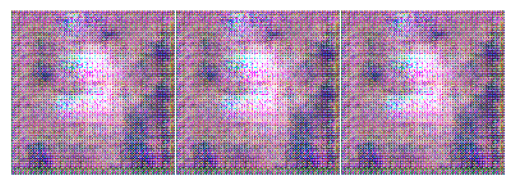

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [103]:
disc_losses, gen_losses = fit(
    generator=generator,
    discriminator=discriminator,
    epochs=16,
    dataloader=dataloader,
    disc_lr=2e-4,
    gen_lr=2e-4,
)

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

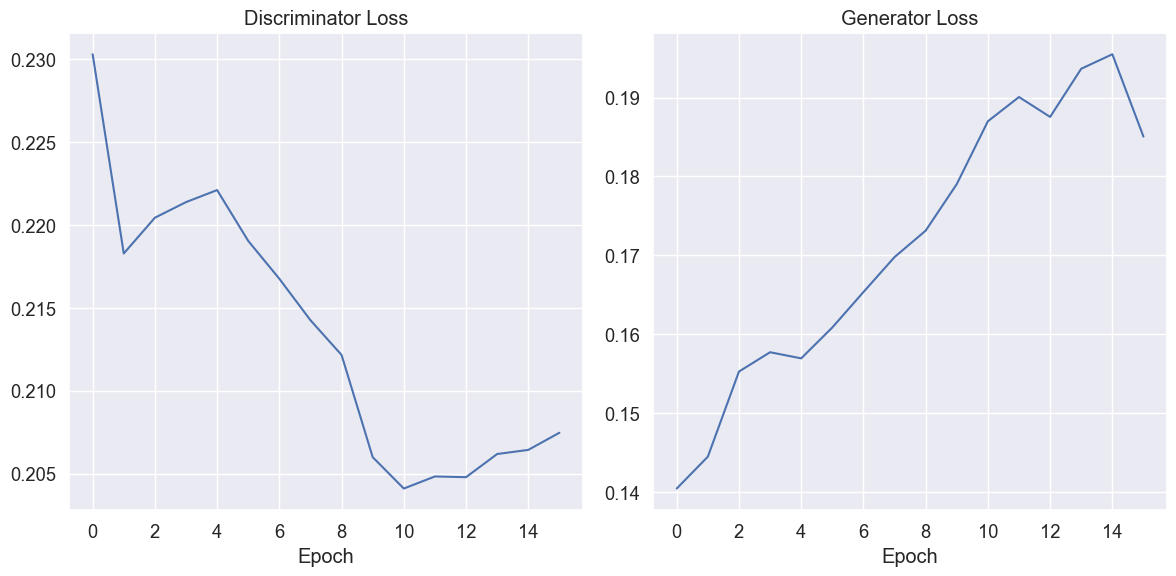

In [101]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

axes[0].plot(disc_losses)
axes[0].set_title("Discriminator Loss")
axes[0].set_xlabel("Epoch")

axes[1].plot(gen_losses)
axes[1].set_title("Generator Loss")
axes[1].set_xlabel("Epoch")

plt.tight_layout()
plt.show()

## Часть 3. Генерация изображений

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [719]:
n_images = 4

fixed_latent = torch.randn(n_images, LATENT_DIM, device=device)
fake_images = generator(fixed_latent)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99572015..0.9222759].


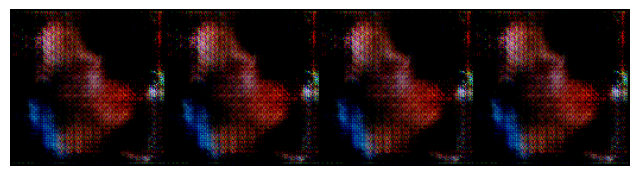

In [720]:
# TODO: show generated images
grid = make_grid(fake_images.detach().cpu(), nrow=n_images)
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")
plt.show()

Как вам качество получившихся изображений?

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (1.5 балл)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

### 4.2. Визуализация распределений (1 балл)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

Прокомментируйте получившийся результат: